In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# Learning rate parameters
BASE_LR = 0.0001
EPOCH_DECAY = 5 # number of epochs after which the Learning rate is decayed exponentially.
DECAY_WEIGHT = 0.5 # factor by which the learning rate is reduced.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
DATA_DIR = r'../input/dataset/data' # to run with the sample dataset, just set to 'hymenoptera_data'

# split the data into train and valid
VALID_SPLIT = 0.8

# DATALOADER PROPERTIES
BATCH_SIZE = 8 # Set as high as possible. If you keep it too high, you'll get an out of memory error.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# If you want to read more, transforms is a function from torchvision, and you can go read more here - http://pytorch.org/docs/master/torchvision/transforms.html
train_transforms = transforms.Compose([
        transforms.Resize((253,349)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1, 2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
val_transforms = transforms.Compose([
        transforms.Resize((253,349)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1, 2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [5]:
# function to create the datasets
def create_datasets():
    """
    Function to build the training, validation, and testing dataset.
    """
    # we choose the `train_dataset` and `valid_dataset` from the same...
    # ... distribution and later one divide 
    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'),
                                         transform = train_transforms)
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'),
                                       transform = val_transforms)
    # this is the final test dataset to be used after training and validation completes
   # test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),
    #                                    transform = val_transforms)
    # get the training dataset size, need this to calculate the...
    # number if validation images   
    # get the training dataset size, need this to calculate the...
    # number if validation images   
    train_dataset_size = len(train_dataset)
    # validation size = number of validation images
    train_size = int(VALID_SPLIT*train_dataset_size)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[train_size,len(train_dataset)-train_size])
    
    print(f"Total training images: {len(train_dataset)}")
    print(f"Total validation images: {len(val_dataset)}")
    print(f"Total test images: {len(test_dataset)}")
    return train_dataset, val_dataset, test_dataset

In [6]:
def create_data_loaders(train_dataset, val_dataset, test_dataset):
    """
    Function to build the data loaders.
    Parameters:
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    :param dataset_test: The test dataset.
    """
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader, val_loader, test_loader

In [7]:
# get the training, validation and test_datasets
train_dataset, val_dataset, test_dataset = create_datasets()
# get the training and validaion data loaders
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset
)

Total training images: 1600
Total validation images: 400
Total test images: 481


In [8]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [9]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'final_model.pt')

In [10]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='dotted', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='dotted', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='dotted', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='dotted', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')

In [12]:
resnet101 = models.resnet101(pretrained=True)
for params in resnet101.parameters():
            params.requires_grad = True
num_ftrs = resnet101.fc.out_features

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [13]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_ftrs, 128)
       # self.relu1 = nn.functional.relu()
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.fc(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        
        return x

In [14]:
net_add = net()
ResnetC101= nn.Sequential(resnet101, net_add)

In [15]:
# This function changes the learning rate over the training model.
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [16]:
# build the model
model = ResnetC101.to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")
# optimizer
optimizer_ft = optim.RMSprop(model.parameters(), lr=0.0001)
# loss function
criterion = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [17]:
exp_lr_scheduler(optimizer_ft,30,init_lr=0.0001)

LR is set to 1.5625e-06


RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 1.5625e-06
    momentum: 0
    weight_decay: 0
)

In [18]:
device

device(type='cuda', index=0)

In [19]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        
        image = image.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        #print(outputs)
        # calculate the loss
        loss = criterion(outputs, labels)
        #print(outputs)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [20]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

[INFO]: Epoch 1 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.581, training acc: 78.875
Validation loss: 0.490, validation acc: 87.750

Best validation loss: 0.4895109307765961

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.488, training acc: 86.188
Validation loss: 0.431, validation acc: 90.000

Best validation loss: 0.43112587451934814

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.441, training acc: 89.062
Validation loss: 0.411, validation acc: 91.750

Best validation loss: 0.4110951429605484

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.427, training acc: 89.562
Validation loss: 0.390, validation acc: 92.750

Best validation loss: 0.38984296917915345

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.414, training acc: 91.000
Validation loss: 0.381, validation acc: 94.000

Best validation loss: 0.3808207726478577

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.400, training acc: 91.500
Validation loss: 0.377, validation acc: 94.500

Best validation loss: 0.3771920388936996

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.397, training acc: 92.250
Validation loss: 0.372, validation acc: 95.000

Best validation loss: 0.37166560113430025

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.380, training acc: 94.000
Validation loss: 0.369, validation acc: 95.000

Best validation loss: 0.3693883663415909

Saving best model for epoch: 8

--------------------------------------------------
[INFO]: Epoch 9 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.389, training acc: 92.688
Validation loss: 0.365, validation acc: 94.750

Best validation loss: 0.36536207020282746

Saving best model for epoch: 9

--------------------------------------------------
[INFO]: Epoch 10 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.385, training acc: 92.812
Validation loss: 0.365, validation acc: 95.000

Best validation loss: 0.3652020490169525

Saving best model for epoch: 10

--------------------------------------------------
[INFO]: Epoch 11 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.374, training acc: 94.125
Validation loss: 0.357, validation acc: 96.000

Best validation loss: 0.35734626710414885

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.380, training acc: 93.500
Validation loss: 0.362, validation acc: 95.500
--------------------------------------------------
[INFO]: Epoch 13 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.369, training acc: 94.750
Validation loss: 0.361, validation acc: 94.750
--------------------------------------------------
[INFO]: Epoch 14 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.371, training acc: 94.438
Validation loss: 0.359, validation acc: 96.000
--------------------------------------------------
[INFO]: Epoch 15 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.376, training acc: 94.000
Validation loss: 0.359, validation acc: 95.500
--------------------------------------------------
[INFO]: Epoch 16 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.360, training acc: 95.438
Validation loss: 0.349, validation acc: 96.500

Best validation loss: 0.3490918231010437

Saving best model for epoch: 16

--------------------------------------------------
[INFO]: Epoch 17 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.366, training acc: 94.812
Validation loss: 0.365, validation acc: 94.500
--------------------------------------------------
[INFO]: Epoch 18 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.359, training acc: 95.125
Validation loss: 0.353, validation acc: 95.750
--------------------------------------------------
[INFO]: Epoch 19 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.355, training acc: 96.188
Validation loss: 0.349, validation acc: 96.500
--------------------------------------------------
[INFO]: Epoch 20 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.351, training acc: 96.375
Validation loss: 0.355, validation acc: 95.750
--------------------------------------------------
[INFO]: Epoch 21 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.355, training acc: 95.875
Validation loss: 0.354, validation acc: 95.500
--------------------------------------------------
[INFO]: Epoch 22 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.347, training acc: 96.938
Validation loss: 0.347, validation acc: 96.750

Best validation loss: 0.34745134234428404

Saving best model for epoch: 22

--------------------------------------------------
[INFO]: Epoch 23 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.350, training acc: 96.375
Validation loss: 0.349, validation acc: 96.250
--------------------------------------------------
[INFO]: Epoch 24 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.349, training acc: 96.500
Validation loss: 0.341, validation acc: 97.250

Best validation loss: 0.34090287089347837

Saving best model for epoch: 24

--------------------------------------------------
[INFO]: Epoch 25 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.357, training acc: 95.500
Validation loss: 0.347, validation acc: 97.000
--------------------------------------------------
[INFO]: Epoch 26 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.349, training acc: 96.750
Validation loss: 0.354, validation acc: 95.750
--------------------------------------------------
[INFO]: Epoch 27 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.351, training acc: 96.188
Validation loss: 0.348, validation acc: 96.750
--------------------------------------------------
[INFO]: Epoch 28 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.355, training acc: 95.625
Validation loss: 0.340, validation acc: 97.500

Best validation loss: 0.33961269319057463

Saving best model for epoch: 28

--------------------------------------------------
[INFO]: Epoch 29 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.347, training acc: 96.750
Validation loss: 0.341, validation acc: 97.500
--------------------------------------------------
[INFO]: Epoch 30 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.343, training acc: 97.312
Validation loss: 0.349, validation acc: 96.500
--------------------------------------------------
[INFO]: Epoch 31 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.342, training acc: 96.938
Validation loss: 0.332, validation acc: 98.000

Best validation loss: 0.3322457838058472

Saving best model for epoch: 31

--------------------------------------------------
[INFO]: Epoch 32 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.350, training acc: 96.562
Validation loss: 0.337, validation acc: 98.000
--------------------------------------------------
[INFO]: Epoch 33 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.341, training acc: 97.375
Validation loss: 0.358, validation acc: 95.500
--------------------------------------------------
[INFO]: Epoch 34 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.344, training acc: 97.188
Validation loss: 0.346, validation acc: 96.500
--------------------------------------------------
[INFO]: Epoch 35 of 35
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 0.349, training acc: 96.250
Validation loss: 0.344, validation acc: 96.750
--------------------------------------------------
Saving final model...
TRAINING COMPLETE


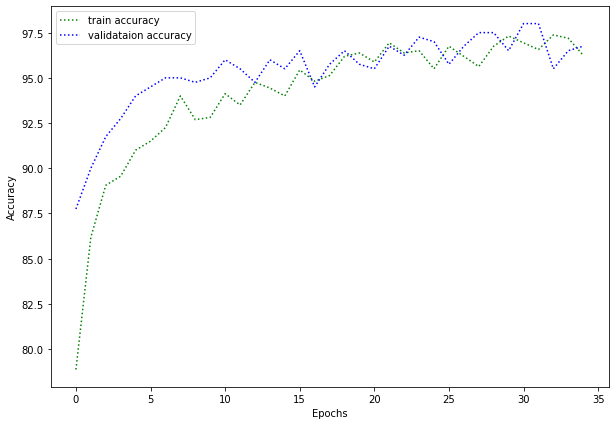

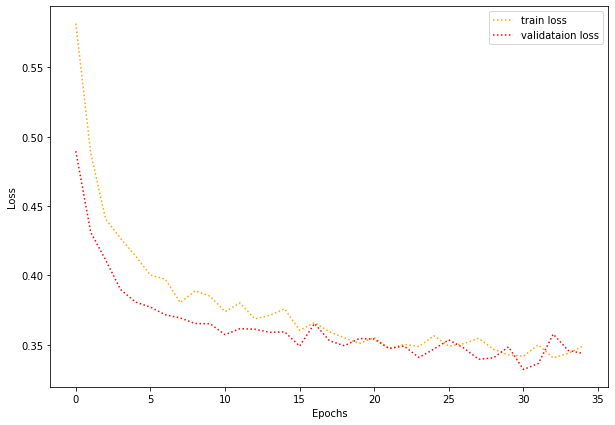

In [21]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
epochs = 35
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    #optimizer = exp_lr_scheduler(optimizer_ft, epochs)
    train_epoch_loss, train_epoch_acc = train(model, train_loader,optimizer_ft, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(valid_epoch_loss, epoch, model, optimizer_ft, criterion)
    print('-'*50)
    
# save the trained model weights for a final time
save_model(epochs, model, optimizer_ft, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [22]:
# Test the model on test samples

confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        print(outputs.shape)
        #print(outputs)
        _,preds = torch.max(outputs,1)
        print(f"preds: {preds}")
        print(f"classes: {classes}")
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

torch.Size([8, 2])
preds: tensor([1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
classes: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
classes: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
classes: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
classes: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
classes: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
classes: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
classes: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
torch.Size([8, 2])
preds: tensor([1, 1, 0, 1, 1, 1, 1, 

In [23]:
print(confusion_matrix.diag().sum()/confusion_matrix.sum())

tensor(0.7048)


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


Accuracy on test data: 0.7089397089397089
Precision: 1.0


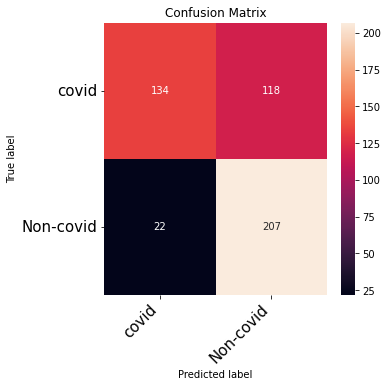

In [25]:
import seaborn as sns
import numpy as np
import pandas as pd
confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))

model.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                
print(f"Accuracy on test data: {confusion_matrix.diagonal().sum()/confusion_matrix.sum()}")
print("Precision:",precision_score(preds.cpu(),classes.cpu()))
plt.figure(figsize=(5,5))

class_names = ['covid','Non-covid']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save model
torch.save(model,'Resnet101-C.pt')